In [1]:
import btk
import cv2 as cv
import numpy as np
import tensorflow as tf
from PIL import Image

tdetect = tf.keras.models.load_model('models\\tdetect-1')
tseg = tf.keras.models.load_model('models\\tseg')
ccls = tf.keras.models.load_model('models\\ccls-h')

In [87]:

def txt_detect(img: np.ndarray, sdims: tuple[int, int], sens: float, sfactor: float = True) -> tuple[int, ...]:
    """
    Use ML model to determine if text appears within an image

    Args:
        img (np.ndarray): Image to analyze
        sens (float): Sensitivity threshold for text detection 

    Returns:
        list[tuple[int, ...], np.ndarray]: Coordinates of regions that have text within the image
    """
    if sfactor:
        sfactor = img.size
    oshape = img.shape
    sc_coeff = (sfactor / img.size)**0.5
    img = btk.resize(img, (round(img.shape[0] * sc_coeff), round(img.shape[1] * sc_coeff)))
    img = btk.fit2dims(img, sdims)
    coord_scale = ((oshape[0] / img.shape[0], oshape[1] / img.shape[1]))
    slices = btk.img_slicer(img, sdims, sdims, 'm')
    coords = btk.gen_index(img.shape, sdims, sdims, 'm')
    predictions = tdetect.predict(slices)
    tcords = []
    for i, x in enumerate(predictions):
        if x > sens:
            tcords.append((coords[i], x[0]))
    for i, x in enumerate(tcords):
        tcords[i] = (np.array([x[0][0] * coord_scale[0],
                            x[0][1] * coord_scale[0],
                            x[0][2] * coord_scale[1],
                            x[0][3] * coord_scale[1]]).astype('uint16'), x[1])
    return tcords

def txt_heat_mapper(img: np.ndarray, sdims: tuple[int, int], sens: float) -> np.ndarray:
    """Generates a heatmap for text locations on an image"""
    img = btk.fit2dims(img, sdims)
    iarea = img.size
    score_card = np.zeros((img.shape[0], img.shape[1]), dtype='float16')
    if iarea < 1048576:
        cords = txt_detect(img, sdims, sens - ((1 - sens) - ((1 - sens) ** 1.666)), iarea * 4)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    if iarea < 2097152:
        cords = txt_detect(img, sdims, sens - ((1 - sens) - ((1 - sens) ** 1.333)), iarea * 2)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    cords = txt_detect(img, sdims, sens, iarea)
    for x in cords:
        score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    if iarea > 2097152:
        cords = txt_detect(img, sdims, sens ** 0.666, iarea / 2)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    if iarea > 4194304:
        cords = txt_detect(img, sdims, sens ** 0.333, iarea / 4)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    return score_card

def expand_coordinates(bounds: tuple[int, ...], idims: tuple[int, int]) -> tuple[int, ...]:
    """Expands coordinate inputs slightly to account for imprecise text detection"""
    for i, x in enumerate(bounds):
        ygap = (x[1] - x[0]) * 0.085
        xgap = (x[3] - x[2]) * 0.085
        bounds[i] = [round(x[0] - ygap), round(x[1] + ygap), round(x[2] - xgap), round(x[3] + xgap)]
    for i, x in enumerate(bounds):
        if x[0] < 0:
            bounds[i][0] = 0
        if x[1] > idims[0]:
            bounds[i][1] = idims[0]
        if x[2] < 0:
            bounds[i][2] = 0
        if x[3] > idims[1]:
            bounds[i][3] = idims[1]
    return bounds

def textract_images(img: np.ndarray, coords: tuple[int, ...]) -> list[np.ndarray]:
    """Extract image regions defineed by coordinate list input"""
    imarr = np.array(img)
    extracted = [imarr[x[0]:x[1], x[2]:x[3]] for x in coords]
    return extracted

def merge_coords(cords: tuple[int, ...]) -> list[tuple[int, ...]]:
    """Merge touching coordinate boxes horizontally and vertically"""
    cords.sort()
    xcombined = []
    ycombined = []
    bay = cords.pop(0)
    while cords:
        if cords[0][0] == bay[0] and cords[0][2] == bay[3]:
            bay[3] = cords[0][3]
            cords.pop(0)
        else:
            xcombined.append(bay)
            bay = cords.pop(0)
    xcombined.append(bay)
    xcombined.sort()
    bay = xcombined.pop(0)
    while xcombined:
        #if xcombined[0][0] == bay[1] and bay[2] == xcombined[0][2] and xcombined[0][3] == bay[3]:
        #    bay[1] = xcombined[0][1]
        #    xcombined.pop(0)
        if xcombined[0][0] == bay[1] and bay[3] > xcombined[0][2] and xcombined[0][3] > bay[2]:
            bay[1] = xcombined[0][1]
            bay[2] = min(xcombined[0][2], bay[2])
            bay[3] = max(xcombined[0][3], bay[3])
            xcombined.pop(0)
        else:
            ycombined.append(bay)
            bay = xcombined.pop(0)
    ycombined.append(bay)
    return ycombined

def get_text(img: np.ndarray, sdims: tuple[int, int], sens: float) -> list[np.ndarray]:
    """
    Identify and extract image regions containing text

    Args:
        img (np.ndarray): Image
        sdims (tuple[int, int]): Dimensions of the image slices
        sens (float): Sensitivity of the detection model

    Returns:
        list[np.ndarray]: Image regions containing text in array form
    """
    imo = btk.sharpen(btk.grey_np(img))
    mtrx = txt_heat_mapper(imo, sdims, sens)
    img = np.invert(imo)
    mtrx += txt_heat_mapper(img, sdims, sens)
    img = cv.adaptiveThreshold(imo, 254, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 19, 30)
    mtrx += txt_heat_mapper(img, sdims, ((1 - sens) * 0.5) + sens)
    mtrx = np.array(mtrx, dtype='uint8')
    mtrx = cv.erode(mtrx, (9, 9), iterations=5)
    #senspoint
    mtrx[mtrx < mtrx.max() * 0.4] = 0
    mtrx[mtrx > 0] = 127
    bounds = []
    for x in cv.findContours(mtrx, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]:
        xset = [y[0][0] for y in x]
        yset = [y[0][1] for y in x]
        bounds.append((min(yset), max(yset), min(xset), max(xset)))
    img = btk.fit2dims(imo, sdims)
    bounds = expand_coordinates(bounds, img.shape)
    bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) > 512]
    if img.shape[0] * img.shape[1] > 262144:
        bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) < img.shape[0] * img.shape[1] * 0.8]
    bounds2 = []
    for x in textract_images(img, bounds):
        #senspoint
        x = btk.resize(x, (round(x.shape[0] * 3 ** 0.5), round(x.shape[1] * 3 ** 0.5)))
        x = btk.fit2dims(x, sdims)
        results = txt_detect(x, sdims, sens, x.size)
        if sum([y[1] for y in results]) > 0.25 * x.size / 4096:
            bounds2.append((x, results))
    bounds.clear()
    for x in bounds2:
        tcords = merge_coords([list(y[0]) for y in x[1]])
        tcords = expand_coordinates(tcords, x[0].shape)
        for y in textract_images(x[0], tcords):
            bounds.append(y)
    bounds = [x for x in bounds if x.size > 7777]
    combined = cv.addWeighted(img, 0.3, mtrx, 0.7, 1)
    display(Image.fromarray(combined))
    return bounds


def sp_predict(slices, sens):
    preds = np.array([x[0] for x in tseg.predict(slices)])
    preds[preds < sens] = 0
    return preds

def row_detect(img, sdims):
    img = np.array(img).T
    #Extract vertical columns from the original image
    cols = [img[round(img.shape[0] * 0.25) - sdims[0]:round(img.shape[0] * 0.25)],
            img[round(img.shape[0] * 0.25):round(img.shape[0] * 0.25) + sdims[0]],
            img[round(img.shape[0] * 0.50) - sdims[0]:round(img.shape[0] * 0.50)],
            img[round(img.shape[0] * 0.50):round(img.shape[0] * 0.50) + sdims[0]],
            img[round(img.shape[0] * 0.75) - sdims[0]:round(img.shape[0] * 0.75)],
            img[round(img.shape[0] * 0.75):round(img.shape[0] * 0.75) + sdims[0]]]
    preds = []
    for y in cols:
        y = btk.force_dim(y, sdims[0], 1)
        imslices = btk.img_slicer(y, sdims, 1, 'v')
        preds.append(sp_predict(imslices, 0.5))
    preds = np.array(preds)
    preds = preds[0] + preds[1] + preds[2] + preds[3]  #space detection based on multiple regions
    preds[preds < 1.666] = 0
    zstart = 0
    display(preds)
    zsections = []
    for i, x in enumerate(preds):
        if i == 0 or i == len(preds) - 1:
            pass
        if preds[i - 1] == 0 and x > 0: #start tracking edge region, indicates text border
            zstart = i
        if preds[i - 1] > 0 and x == 0: #leaving text border region
            zend = i
            if zend - zstart > 3:   #Text borders will generally be more than 3 pixels
                zsections.append((zstart, zend))  #add border region coords, text will be between two borders
    #display(zsections)
    border = round(sum([x[1] - x[0] for x in zsections]) / len(zsections) / 2)
    zsections = [(x[1] - border, zsections[i + 1][1] + border) for i, x in enumerate(zsections) if i != len(zsections) - 1]
    rows = [img.T[x[0]:x[1]] for x in zsections]
    if len(rows) == 0:
        rows.append(img.T)
    return rows

def chopper(img, divs):
    img = np.array(img)
    if divs[-1] - len(divs) >= 32:
        divs.append(divs[-1] + 32)
    else:
        divs.append(len(img[0]) - 1)
    cpack = []
    for i, x in enumerate(divs):
        if i == len(divs) - 1:
            break
        if divs[i + 1] - x >= 4:
            cpack.append(Image.fromarray(img[:, x:divs[i + 1]]))
    return cpack

def grouper(inp: list, min=1, dist=3):
    inp.sort()
    last = 0
    vals = []
    confirmed = []
    for x in inp:
        if x - last >= dist:
            vals.append(last)
            if len(vals) >= min:
                confirmed.append(round(sum(vals) / len(vals)))
            vals = []
            last = x
        else:
            vals.append(last)
            last = x
    confirmed.append(last)
    return confirmed

def split_letters(img, dims, sens):
    img = btk.force_dim(img, dims[0], 1)
    split = [img, np.invert(img)]
    temp = []
    for x in split:
        slices = btk.img_slicer(x, dims, 1, 'v')
        temp.append(np.array(sp_predict(slices, sens / 4)))
    preds = (temp[0] + temp[1]) / 2
    preds[preds < sens] = 0
    idx = btk.gen_index(img.shape, (32, 12), 1, 'v')
    crits = btk.criticals(btk.smooth_avg(btk.smooth_avg(preds)), idx)
    crits = [int(btk.halfpoint(x[0][0], x[0][1])) for x in crits if x[1] == 'max']
    crits = grouper(crits)
    return chopper(img, crits)



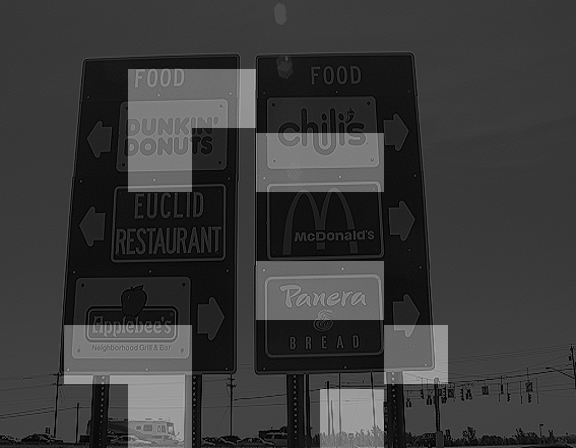

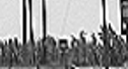

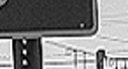

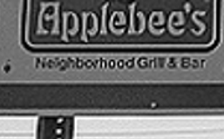

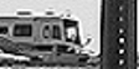

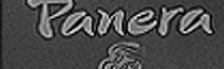

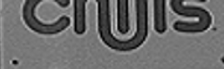

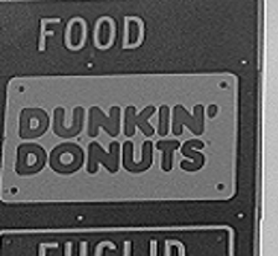

In [88]:
with Image.open(f"testimgs\\t24.png") as f:
    imo = np.array(f)

texts = get_text(imo, (64, 64), 0.666)
for x in texts:
    display(Image.fromarray(x))

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       1.9533774, 2.076733 , 2.4103665, 3.081115 , 3.1348655, 3.3254986,
       3.2824152, 2.7921424, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 1.6892507, 0.       ,
       2.0003662, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 2.534764 , 2.5236235,
       3.3473315, 3.2238145, 3.3099904, 2.5661845, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 1.8572986, 1.9335796,
       1.7427921, 0.       , 1.6766241, 0.       , 

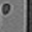

In [94]:
rows = row_detect(texts[6], (32, 12))
row = rows[2]

letters = split_letters(row, (32, 12), 0.8)
for x in letters:
    display(x)